第6章　カーネル法
==

* カーネル関数を，特徴空間における内積として捉えることで，**カーネルトリック**(kernel trick)あるいは**カーネル置換**(kernel substitution)と呼ばれるテクニックを用いて，多くの良く知られたアルゴリズムを拡張することが出来るようになる。もし学習アルゴリズムにおいて，入力ベクトルxが，スカラー積の中にのみ現れるならならば，スカラー積を何らかのカーネル関数で置き換えることが出来るというものである。

Nadaraya-Watsonモデル
--
### $y(\mathbf{x})=\sum_{n=1}^{N}{t_nh(\mathbf{x}-\mathbf{x}_n)}$
### $h(\mathbf{x}-\mathbf{x}_n)=\frac{\nu(\mathbf{x}-\mathbf{x}_n)}{\sum_{n=1}^{N}{\nu(\mathbf{x}-\mathbf{x}_n)}}$
等方的なガウスカーネル
--
### $\nu(\mathbf{x}) = \cal{N}(0, \sigma^2)$

In [103]:
from matplotlib.font_manager import FontProperties

# matplotlibで日本語フォント
fp = FontProperties(fname=r'/System/Library/Fonts/ヒラギノ角ゴ ProN W3')

0.0429375545291 0.06772126445


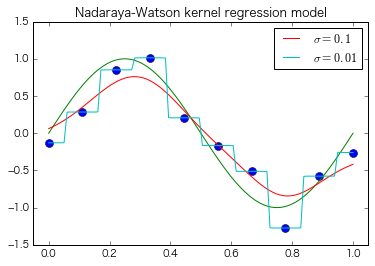

In [220]:
# 正弦波の人工データ
np.random.seed(71)
X_train = np.linspace(0, 1, num=10)
y_train = np.sin(X_train * 2 * np.pi) + np.random.randn(len(X_train)) * 0.3
X_test = np.linspace(0, 1, num=100)
y_test = np.sin(X_test * 2 * np.pi)

# Nadaraya-Watson kernel regression
class NadarayaWatson(object):
    def __init__(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train
        
    def predict(self, x, sig):
        dx = (x - self.X_train) / sig
        h = np.exp(-0.5 * (dx ** 2))
        h /= h.sum()
        return np.dot(h, self.y_train)

nw = NadarayaWatson(X_train, y_train)
y_pred = map(nw.predict, X_test, [0.1] * len(X_test))
y_pred2 = map(nw.predict, X_test, [0.01] * len(X_test))

plt.plot(X_train, y_train, 'o', markersize=8)
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred, label='$\sigma=0.1$')
plt.plot(X_test, y_pred2, label='$\sigma=0.01$')
plt.legend(loc='best')
plt.title('Nadaraya-Watson kernel regression model')
plt.xlim(-0.05, 1.05)

print ((y_test - y_pred) ** 2).mean(), ((y_test - y_pred2) ** 2).mean()
plt.savefig('NadarayaWatson.png', dpi=220)

条件付き分散の計算の仕方は分からんかった…

ガウス過程
--
### 線形回帰
### $y(\mathbf{x})=\mathbf{w}^{T}\phi(\mathbf{x})$ 
### 重みwの事前分布（等方的なガウス分布）
### $p(\mathbf{w})=\cal{N}(w|0, \alpha^{-1}\mathbf{I})$
### $\mathbf{y}=\mathbf{\Phi}\mathbf{w}$
$\mathbf{\Phi}$は$N×M$のデザイン行列<br><br> 
yはガウス分布であるwの線形結合なので、yもガウス分布となる。<br>よって平均と共分散を求めれば十分である。
### $\mathbb{E}[\mathbf{y}]=\mathbf{\Phi}\mathbb{E}[\mathbf{w}]=0$
### $\rm{cov}[\mathbf{y}]=\mathbb{E}[\mathbf{y}\mathbf{y}^{T}]=\Phi\mathbb{E}[\mathbf{w}\mathbf{w}^{T}]\Phi^{T}=\frac{1}{\alpha}\Phi\Phi^{T}=\mathbf{K}$ 
### $K_{nm}=k(x_{n},x_{m})=\frac{1}{\alpha}\phi(\mathbf{x}_{n})^{T}\phi(\mathbf{x}_{m})$
$\mathbf{K}$は$K_{nm}$を要素に持つグラム行列。$k(\mathbf{x}, \mathbf{x}')$はカーネル関数である。 
オルンシュタインーウーレンベック過程(Ornstein-Uhlenbeck process)
--
### $ k(\mathbf{x},\mathbf{x}')=exp(-\theta|\mathbf{x}-\mathbf{x}'|)$
指数カーネル

/Library/Python/2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: covariance is not positive-semidefinite.


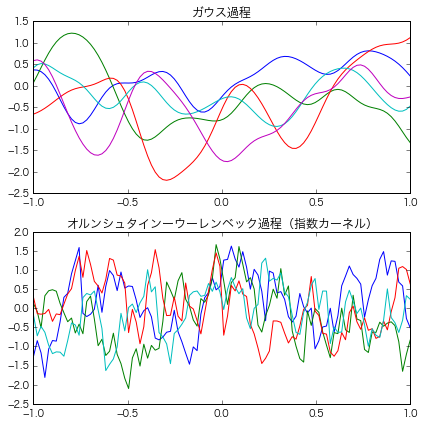

In [219]:
# ガウス過程、オルンシュタインーウーレンベック過程による関数のサンプル
np.random.seed(71)
alpha = 7.
x = np.linspace(1, -1, 100)

class GaussianProcess(object):
    """ ガウス過程 """
    def __init__(self, x, alpha):
        self.x = x
        self.cov = np.zeros((len(x), len(x)))
        self.mean = np.zeros(len(x))
        self.alpha = alpha
    
    def fit(self):
        z = np.sqrt(2 * np.pi)
        for i in xrange(len(x)):
            dx = (self.x - self.x[i]) * self.alpha
            h = np.exp(-0.5 * (dx ** 2)) / z
            self.cov[i] = h
           
    def sample(self):
        return np.random.multivariate_normal(self.mean, self.cov)

class OrnsteinUhlenbeckProcess(object):
    """ オルンシュタインーウーレンベック過程 """
    def __init__(self, x, alpha):
        self.x = x
        self.cov = np.zeros((len(x), len(x)))
        self.mean = np.zeros(len(x))
        self.alpha = alpha

    def fit(self):
        for i in xrange(len(x)):
            dx = (self.x - self.x[i]) * self.alpha
            h = np.exp(-np.abs(dx))
            self.cov[i] = h
           
    def sample(self):
        return np.random.multivariate_normal(self.mean, self.cov)

gp = GaussianProcess(x, alpha)
gp.fit()
ou = OrnsteinUhlenbeckProcess(x, alpha)
ou.fit()

plt.figure(figsize=(6, 6))

plt.subplot(211)
for _ in xrange(5):
    plt.plot(x, gp.sample())
plt.title(u'ガウス過程')

plt.subplot(212)    
for i in xrange(4):
    plt.plot(x, ou.sample())
plt.title(u'オルンシュタインーウーレンベック過程（指数カーネル）')
    
plt.tight_layout()
plt.savefig('GaussianProcess.png', dpi=220)

ガウス過程による回帰
--
### $k(\mathbf{x}_n, \mathbf{x}_m)=\theta_0exp\{-\frac{\theta_1}{2}\|\mathbf{x}_n-\mathbf{x}_m\|^2\}+\theta_2+\theta_3\mathbf{x}_n^T\mathbf{x}_m$
ガウス過程回帰に用いるカーネル。2次形式の指数をとったものに、定数と線形の項を加えたもの。

/Library/Python/2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: covariance is not positive-semidefinite.


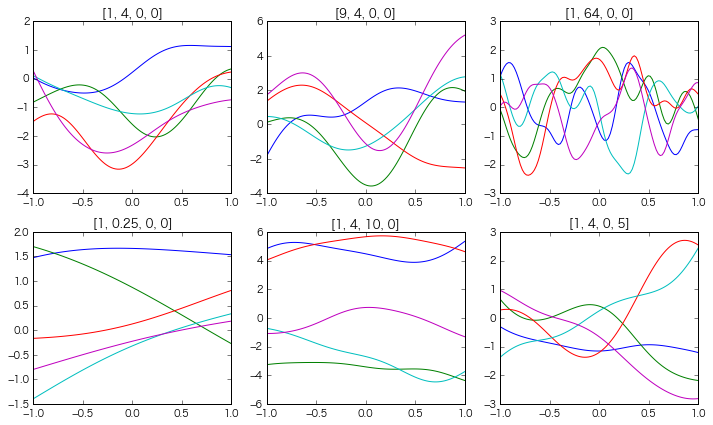

In [218]:
# ガウス過程による事前分布からのサンプル
np.random.seed(71)
x = np.linspace(1, -1, 100)

class GaussianProcess2(object):
    """ ガウス過程2 """
    def __init__(self, x, theta):
        self.x = x
        self.cov = np.zeros((len(x), len(x)))
        self.mean = np.zeros(len(x))
        self.theta = theta
    
    def fit(self):
        for i in xrange(len(self.x)):
            dx = (self.x - self.x[i])
            h = np.exp(-0.5 * self.theta[1] * (dx ** 2) ) * self.theta[0]
            h += self.theta[2] + self.x * self.x[i] * self.theta[3]
            self.cov[i] = h
        
    def sample(self):
        return np.random.multivariate_normal(self.mean, self.cov)

fig, ax = plt.subplots(2, 3, figsize=(10, 6))
ax = ax.flatten()
for i, theta in enumerate([[1, 4, 0, 0], [9, 4, 0, 0], [1, 64, 0, 0], [1, 0.25, 0, 0], [1, 4, 10, 0], [1, 4, 0, 5]]):
    gp = GaussianProcess2(x, theta)
    gp.fit()

    for _ in xrange(5):
        ax[i].plot(x, gp.sample())
    ax[i].set_title(theta)
        
plt.tight_layout()
plt.savefig('GaussianProcess2.png', dpi=220)

0.0189397445049


(-0.05, 1.05)

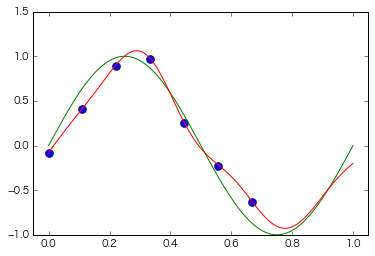

In [216]:
# 正弦波の人工データ
np.random.seed(71)
sig = 0.2
X_train = np.linspace(0, 1, num=10)[:-3]
y_train = np.sin(X_train * 2 * np.pi) + np.random.randn(len(X_train)) * sig
X_test = np.linspace(0, 1, num=100)
y_test = np.sin(X_test * 2 * np.pi)

class GaussianProcess3(object):
    """ ガウス過程3 """
    def __init__(self, x, t, beta, theta):
        self.x = x
        self.t = t
        self.cov = np.zeros((len(x), len(x)))
        self.cov_i = np.zeros((len(x), len(x)))
        self.beta = beta
        self.theta = theta
    
    def fit(self):
        for i in xrange(len(self.x)):
            dx = (self.x - self.x[i])
            h = np.exp(-0.5 * self.theta[1] * (dx ** 2) ) * self.theta[0]
            h += self.theta[2] + self.x * self.x[i] * self.theta[3]
            self.cov[i] = h
        self.cov += self.beta
        self.cov_i = np.linalg.inv(self.cov)

    def sample(self):
        return np.random.multivariate_normal(np.zeros(len(self.x)), self.cov)

    def cal_k(self, x1):
        dx = (self.x - x1)
        h = np.exp(-0.5 * self.theta[1] * (dx ** 2) ) * self.theta[0]
        h += self.theta[2] + self.x * x1 * self.theta[3]
        return h

    def predict(self, x1):
        k = self.cal_k(x1)
        mean1 = np.dot(k, np.dot(self.cov_i, self.t))
        return mean1

gp = GaussianProcess3(X_train, y_train, sig ** 2, [1, 44, 0, 0])
gp.fit()
y_pred = map(gp.predict, X_test)
print ((y_test - y_pred) ** 2).mean()
    
plt.plot(X_train, y_train, 'o', markersize=8)
plt.plot(X_test, y_test)
plt.plot(X_test, y_pred)
plt.xlim(-0.05, 1.05)